In [1]:
import numpy as np
import pandas as pd
import polars as pl

import seaborn as sns
import matplotlib.pyplot as plt
import catboost as cb

from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import classification_report
from sklearn.utils import compute_class_weight
from sklearn.model_selection import train_test_split

import util

In [2]:
RANDOM_SEED = 42
RATIO_LOWER_BOUND = 0.95

In [3]:
ORIGINS_PATH = "/storage2/tbrekalo/HG002-simulated/chr19-read-origins.csv"
df_origins = util.load_origins_df(ORIGINS_PATH)

In [4]:
MINIMAP2_OVLPS = "/storage2/tbrekalo/HG002-simulated/chr19-sample-minimap2-ovlps.paf"
TB_RAM_OVLPS_AI = "/storage2/tbrekalo/HG002-simulated/chr19-sample-tb-ram-ovlps-ai.tsv"
RAM_OVLPS = "/storage2/tbrekalo/HG002-simulated/chr19-sample-ram-ovlps.paf"

In [5]:
df_ovlps_minimap2 = util.create_annotated_overlaps_from_ava(
    util.load_paf_df(MINIMAP2_OVLPS),
    df_origins,
    min_ratio=RATIO_LOWER_BOUND,
).filter(pl.col("query-name") != pl.col("target-name"))

In [6]:
util.calc_ava_origin_overlap(
    util.expand_ava_with_origin_info(
        util.load_paf_df(MINIMAP2_OVLPS).filter(
            pl.col("query-name") != pl.col("target-name")
        ),
        df_origins,
    )
).filter(pl.col("ratio") > RATIO_LOWER_BOUND).sort("ratio").select(
    "query-origin-start",
    "query-origin-end",
    "query-origin-strand",
    "target-origin-start",
    "target-origin-end",
    "target-origin-strand",
    "ratio",
    "matching-strands",
)

query-origin-start,query-origin-end,query-origin-strand,target-origin-start,target-origin-end,target-origin-strand,ratio,matching-strands
i64,i64,str,i64,i64,str,f64,bool
45197302,45217574,"""+""",45196527,45216579,"""+""",0.950918,true
45197302,45217574,"""+""",45196527,45216579,"""+""",0.950918,true
45197302,45217574,"""+""",45196527,45216579,"""+""",0.950918,true
23696852,23713915,"""+""",23691023,23713093,"""+""",0.951826,true
23696852,23713915,"""+""",23691023,23713093,"""+""",0.951826,false
29400167,29417663,"""-""",29399871,29418544,"""-""",0.95206,true
29400167,29417663,"""-""",29399871,29418544,"""-""",0.95206,false
29400167,29417663,"""-""",29399871,29418544,"""-""",0.95206,true
29400167,29417663,"""-""",29399871,29418544,"""-""",0.95206,true


In [7]:
def create_df_ai_ram(input_path: str, df_origins: pl.DataFrame) -> pl.DataFrame:
    return (
        util.calc_ava_origin_overlap(
            util.expand_ava_with_origin_info(
                df_ava=pl.read_csv(
                    input_path,
                    has_header=False,
                    new_columns=util.RAM_OVERLAP_AI_COLUMNS,
                    separator="\t",
                ),
                df_origins=df_origins,
            )
        )
        .select(
            *util.RAM_OVERLAP_AI_COLUMNS,
            ((pl.col("ratio") > RATIO_LOWER_BOUND))
            .cast(pl.Int64)
            .alias("label"),
        )
        .with_columns(
            pl.when(pl.col("strand") == "+")
            .then(pl.lit(1))
            .otherwise(pl.lit(0))
            .alias("strand"),
            pl.min_horizontal(
                pl.col("query-matches"),
                pl.col("target-matches"),
            ).alias("n-residue-matches"),
        )
    )


df_ovlps_tb_ram = create_df_ai_ram(TB_RAM_OVLPS_AI, df_origins)

In [8]:
df_ovlps_ram = util.create_annotated_overlaps_from_ava(
    util.load_paf_df(RAM_OVLPS),
    df_origins,
    min_ratio=RATIO_LOWER_BOUND,
)

In [9]:
print(df_ovlps_minimap2.select(pl.col("label").value_counts()))
print(df_ovlps_tb_ram.select(pl.col("label").value_counts()))
print(df_ovlps_ram.select(pl.col("label").value_counts()))

shape: (2, 1)
┌────────────┐
│ label      │
│ ---        │
│ struct[2]  │
╞════════════╡
│ {0,296281} │
│ {1,178}    │
└────────────┘
shape: (2, 1)
┌───────────┐
│ label     │
│ ---       │
│ struct[2] │
╞═══════════╡
│ {0,86394} │
│ {1,242}   │
└───────────┘
shape: (2, 1)
┌────────────┐
│ label      │
│ ---        │
│ struct[2]  │
╞════════════╡
│ {0,126055} │
│ {1,67}     │
└────────────┘


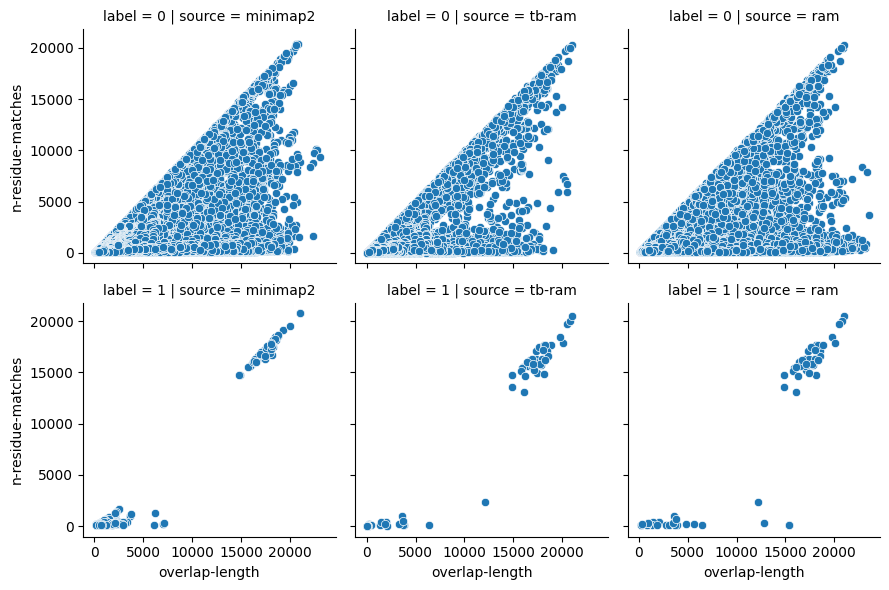

In [10]:
dfs = {
    "minimap2": df_ovlps_minimap2,
    "tb-ram": df_ovlps_tb_ram,
    "ram": df_ovlps_ram,
}


def overlap_metrics(df_in: pl.DataFrame, source: str) -> pl.DataFrame:
    return df_in.select(*util.PAF_COLUMNS, "label").with_columns(
        pl.max_horizontal(
            (pl.col("query-end") - pl.col("query-start")),
            (pl.col("target-end") - pl.col("target-start")),
        ).alias("overlap-length"),
        pl.lit(source).alias("source"),
    )


df_overlaps = pl.concat([overlap_metrics(df, name) for name, df in dfs.items()])
g = sns.FacetGrid(
    df_overlaps.to_pandas(), col="source", row="label"
)
g.map_dataframe(
    sns.scatterplot,
    x="overlap-length",
    y="n-residue-matches",
)

In [11]:
df_overlaps.group_by(
    "label",
    "source",
).agg(
    pl.struct(["query-name", "target-name"]).n_unique().alias("n-unique-pairs"),
    pl.col("overlap-length").mean().alias("overlap-length-mean"),
    pl.col("overlap-length").std().alias("overlap-length-std"),
    pl.col("overlap-length").quantile(0.25).alias("overlap-length-q25"),
    pl.col("overlap-length").median().alias("overlap-length-median"),
    pl.col("overlap-length").quantile(0.75).alias("overlap-length-q75"),
).sort(by=["source", "label"])

label,source,n-unique-pairs,overlap-length-mean,overlap-length-std,overlap-length-q25,overlap-length-median,overlap-length-q75
i64,str,u32,f64,f64,f64,f64,f64
0,"""minimap2""",142718,2672.915651,3305.785516,540.0,1242.0,3413.0
1,"""minimap2""",42,5041.146067,7069.570008,438.0,1058.0,6218.0
0,"""ram""",84202,3688.159415,3870.434921,972.0,2131.0,5036.0
1,"""ram""",38,11690.208955,7472.860623,3601.0,16032.0,17760.0
0,"""tb-ram""",52857,1930.425111,2478.439592,405.0,1050.0,2517.0
1,"""tb-ram""",38,2991.417355,6426.393709,24.0,28.0,120.0


In [12]:
df_ovlps_minimap2.filter(label=1).group_by(
    "query-name",
    "target-name",
    "strand",
).agg(
    pl.len(),
).filter(
    pl.col("len") > 1,
).select(
    "query-name",
    "target-name",
).join(
    df_ovlps_tb_ram,
    on=[
        "query-name",
        "target-name",
    ],
).sort("strand", "query-name", "target-name", "query-start", "query-end", "target-start", "target-end",)

query-name,target-name,query-length,query-start,query-end,query-matches,strand,target-length,target-start,target-end,target-matches,score,diff-mean,q75,q90,q95,q98,label,n-residue-matches
str,str,i64,i64,i64,i64,i32,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,i64,i64
"""S1_13607_chr19…","""S1_68117_chr19…",18151,3512,9936,133,0,20586,5328,11739,133,219.015854,400.5625,83,179,5849,5849,1,133
"""S1_13607_chr19…","""S1_68117_chr19…",18151,3512,9936,133,0,20586,5328,11739,133,219.015854,400.5625,83,179,5849,5849,1,133
"""S1_13607_chr19…","""S1_68117_chr19…",18151,5065,17220,2335,0,20586,6875,19014,2341,4327.955,24.183267,5,22,36,76,1,2335
"""S1_13607_chr19…","""S1_68117_chr19…",18151,5065,17220,2335,0,20586,6875,19014,2341,4327.955,24.183267,5,22,36,76,1,2335
"""S1_13607_chr19…","""S1_68117_chr19…",18151,16135,16159,24,0,20586,7576,7600,24,1640.035532,3.0,5,5,5,5,1,24
"""S1_13607_chr19…","""S1_68117_chr19…",18151,16135,16159,24,0,20586,7576,7600,24,1640.035532,3.0,5,5,5,5,1,24
"""S1_16155_chr19…","""S1_356_chr19""",20036,4,20034,17846,0,20987,392,20437,17849,35664.6,3.852743,4,5,7,18,1,17846
"""S1_16155_chr19…","""S1_356_chr19""",20036,5847,5872,25,0,20987,14870,14895,25,5128.378413,3.333333,5,5,5,5,1,25
"""S1_16155_chr19…","""S1_356_chr19""",20036,5869,5953,39,0,20987,14614,14698,39,5309.25,17.25,60,60,60,60,1,39


In [13]:
FEATURE_COLS = [
    "diff-mean",
    "q75",
    "q90",
    "q95",
    "q98",
    "query-matches-normed",
    "target-matches-normed",
    "matches-normed",
    "score-normed",
    "matches-normed-diff",
    "label",
]
df_experiment = (
    (
        df_ovlps_tb_ram.with_columns(
            (pl.col("query-end") - pl.col("query-start")).alias("query-overlap-length"),
            (pl.col("target-end") - pl.col("target-start")).alias(
                "target-overlap-length"
            ),
        )
        .with_columns(
            pl.max_horizontal(
                pl.col("query-overlap-length"),
                pl.col("target-overlap-length"),
            ).alias("overlap-length"),
            (pl.col("query-overlap-length") - pl.col("target-overlap-length"))
            .abs()
            .alias("overlap-length-diff"),
        )
        .with_columns(
            (pl.col("query-matches") / pl.col("query-overlap-length")).alias(
                "query-matches-normed"
            ),
            (pl.col("target-matches") / pl.col("target-overlap-length")).alias(
                "target-matches-normed"
            ),
            (pl.col("n-residue-matches") / pl.col("overlap-length")).alias(
                "matches-normed"
            ),
            (pl.col("score") / pl.col("overlap-length")).alias("score-normed")
        )
        .with_columns(
            (pl.col("query-matches-normed") - pl.col("target-matches-normed"))
            .abs()
            .alias("matches-normed-diff")
        )
    )
    .group_by("query-name", "target-name", "strand")
    .agg(
        *FEATURE_COLS,
        pl.len().alias("n-group-overlaps"),
    )
    .explode(FEATURE_COLS)
    .drop(
        "strand",
        "query-name",
        "target-name",
        "n-group-overlaps",
    )
)

<Axes: >

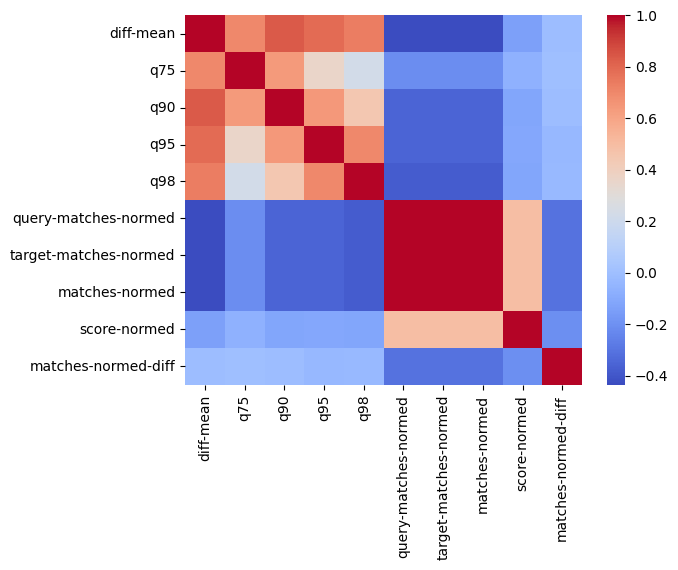

In [14]:
sns.heatmap(df_experiment.drop("label").to_pandas().corr(), cmap="coolwarm")

<Axes: xlabel='query-matches-normed', ylabel='target-matches-normed'>

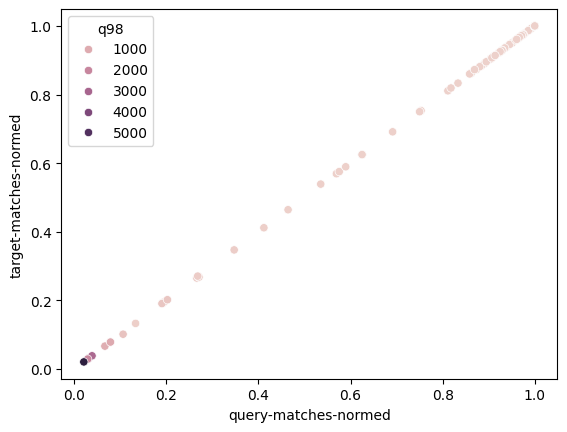

In [15]:
sns.scatterplot(
    df_experiment.filter(
        label=1
    ).filter(
        (pl.col("target-matches-normed") - pl.col("query-matches-normed")).abs() < 1
    ).to_pandas(), x="query-matches-normed", y="target-matches-normed", hue="q98")

In [16]:
palette = {
    0: "blue",
    1: "orange",
}

<Axes: xlabel='query-matches-normed', ylabel='target-matches-normed'>

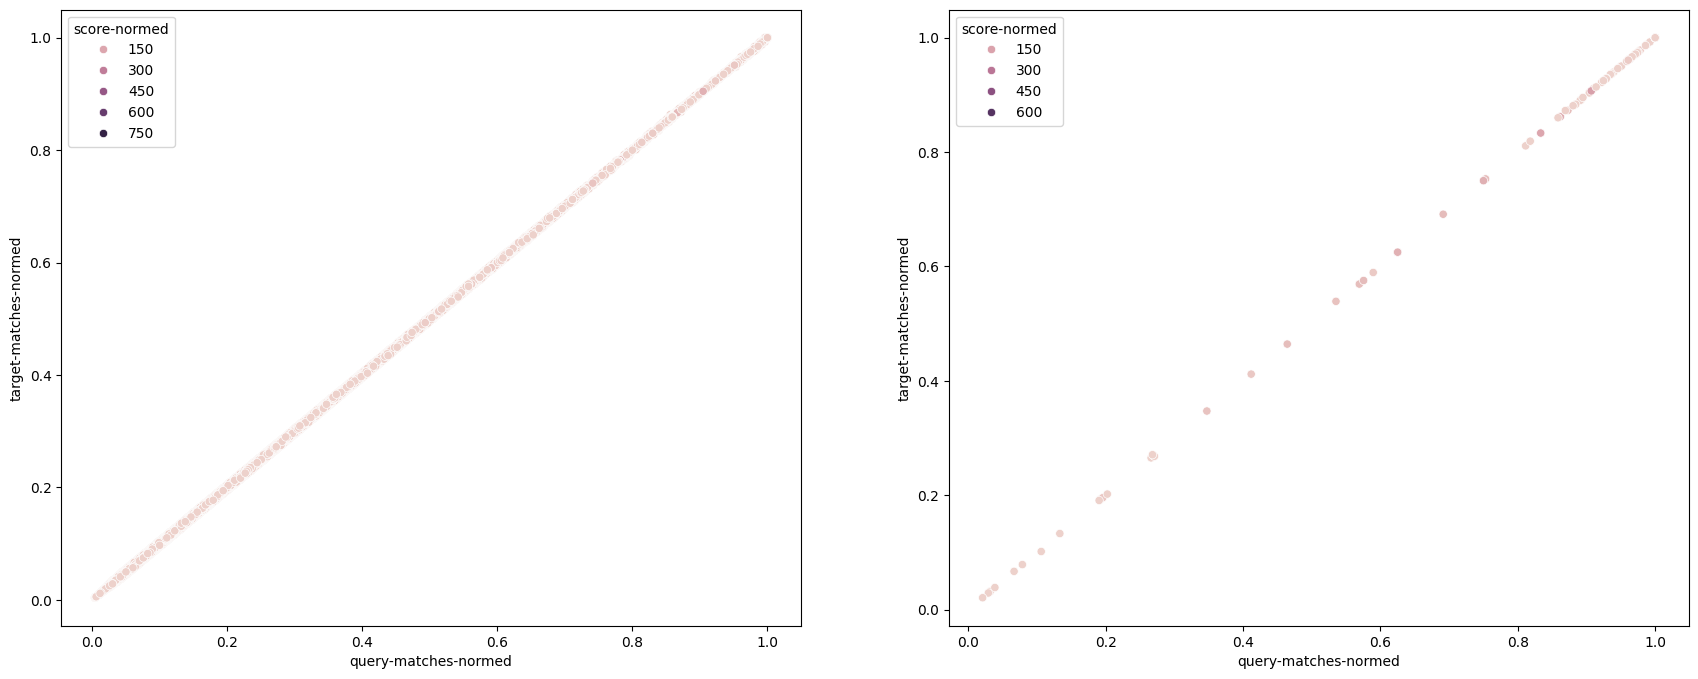

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(21, 8))
sns.scatterplot(df_experiment.filter(label=0).to_pandas(), x="query-matches-normed", y="target-matches-normed", hue="score-normed", ax=ax[0])
sns.scatterplot(df_experiment.filter(label=1).to_pandas(), x="query-matches-normed", y="target-matches-normed", hue="score-normed", ax=ax[1])

In [18]:
MODEL_FEATURES = [
    "score-normed",
    "diff-mean",
    "q75",
    "q90",
    "q95",
    "q98",
]

df_model_features = df_experiment.select(
    *MODEL_FEATURES,
    "label",
)

In [19]:
df_train, df_test = train_test_split(
    df_model_features.to_pandas(),
    train_size=0.7,
    random_state=RANDOM_SEED,
)

class_weights={k: v for k, v in zip([0, 1], compute_class_weight(class_weight="balanced",  classes=np.unique(df_train["label"]), y=df_train["label"],))}

In [20]:
model = RidgeClassifier(class_weight=class_weights)
model.fit(df_train.drop("label", axis=1), df_train["label"])
y_model_pred = model.predict(df_test.drop("label", axis=1))
print(
    classification_report(
        y_true=df_test["label"],
        y_pred=y_model_pred,
    )
)

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     25929
           1       0.03      0.71      0.06        62

    accuracy                           0.95     25991
   macro avg       0.52      0.83      0.52     25991
weighted avg       1.00      0.95      0.97     25991



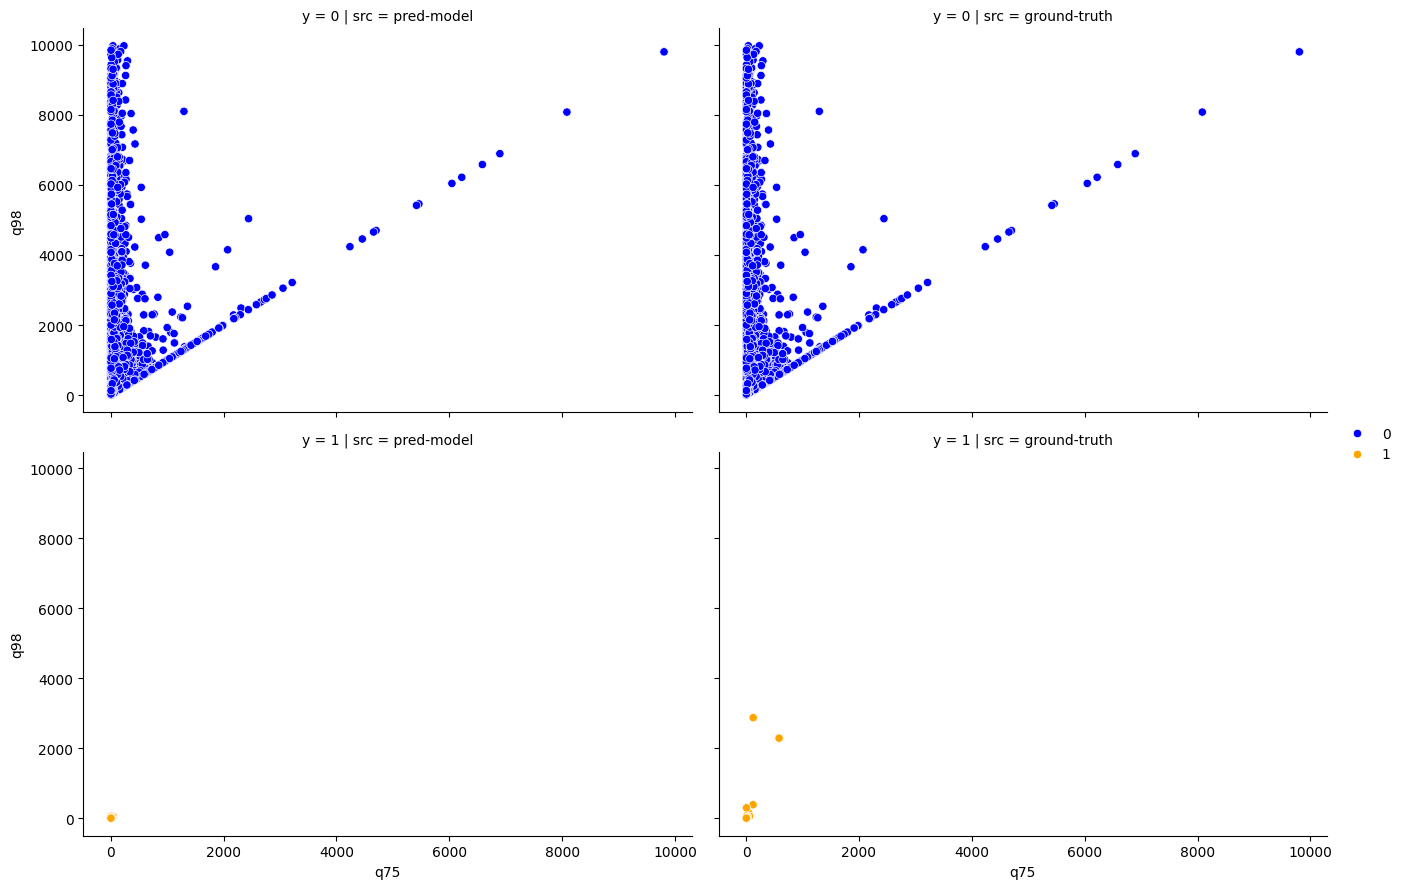

In [21]:
df_result = pd.concat(
    [
        df_test.assign(y=y_model_pred, src="pred-model"),
        df_test.assign(y=df_test["label"], src="ground-truth"),
    ],
)
g = sns.FacetGrid(df_result, col="src", row="y")
g.fig.set_size_inches(13.5, 9)
g.map_dataframe(
    sns.scatterplot,
    x="q75",
    y="q98",
    hue="y",
    palette={
        0: 'blue',
        1: 'orange',
    },
)
g.add_legend()

In [22]:
sorted(
    list(zip(model.feature_names_in_, model.coef_[0])),
    key=lambda kv: kv[1] ** 2,
    reverse=True,
)

[('score-normed', 0.002958350682281503),
 ('diff-mean', -0.0024195857925894313),
 ('q95', 0.0002288738395194311),
 ('q90', -0.0002018138473679244),
 ('q75', 0.0001158280178522951),
 ('q98', -0.00011253146378776396)]

In [23]:
params = {
    'eval_metric': 'AUC',
    'iterations': 200,
    'learning_rate': .1,
    'depth': 2,
    'class_weights': {
        0: 1,
        1: 50,
    },
    'verbose': False,
}

cb_model = cb.CatBoostClassifier(**params)

cb_model.fit(
    df_train.drop("label", axis=1), df_train["label"],
    eval_set=(df_test.drop("label", axis=1), df_test["label"]),
    use_best_model=True,
    plot=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [24]:
y_pred_cb=cb_model.predict(df_test.drop("label", axis=1))
print(
    classification_report(
        y_true=df_test["label"], y_pred=y_pred_cb,
    )
)

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     25929
           1       0.05      0.69      0.09        62

    accuracy                           0.97     25991
   macro avg       0.52      0.83      0.54     25991
weighted avg       1.00      0.97      0.98     25991

